In [1]:
# Import Print function

from __future__ import print_function

In [2]:
# Add manual seed for deterministic results
import torch
torch.manual_seed(1)

# Set Constant Values
batch_size = 32
class_map = {
    'ZERO': 0,
    'ONE': 1,
    'TWO': 2,
    'THREE': 3,
    'FOUR': 4,
    'FIVE': 5,
    'SIX': 6,
    'SEVEN': 7,
    'EIGHT': 8,
    'NINE': 9
}

# Enable or disable visualizations
show_summary = True
show_dataset_analyze = True

In [3]:
from mnist.utils import get_device

# Check GPU availability
use_cuda, device = get_device()

In [4]:
# Load test and train loaders
from mnist.dataset import get_loader
# Get transforme functions
from mnist.transform import get_a_train_transform, get_a_test_transform

# create train and test loaders with transforms
train_loader, test_loader = get_loader(get_a_train_transform(), get_a_test_transform(), batch_size=batch_size, use_cuda=use_cuda)

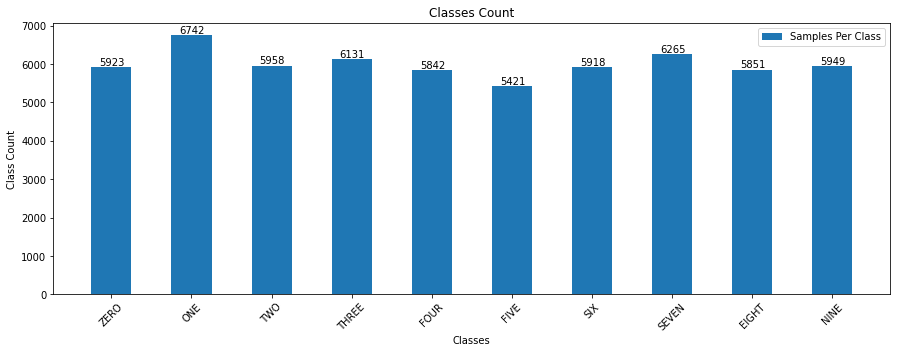

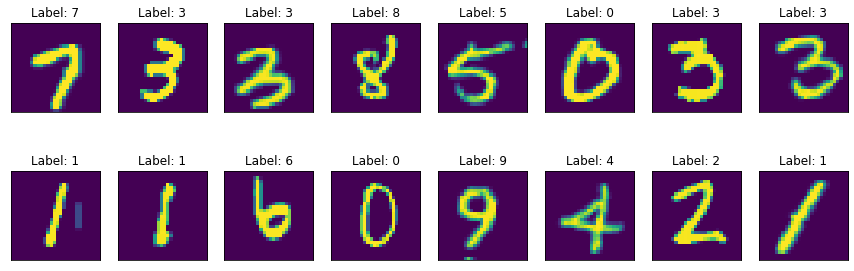

In [5]:
# We will now visualize DataSet by printing data scale and some samples
from mnist.visualize import print_class_scale, print_samples
if show_dataset_analyze:
    # print class scale
    print_class_scale(train_loader, class_map)
    # print data samples
    print_samples(train_loader)

## Load and Train Network

1. Here we will first set all hyper parameters
2. Create instances for three different models
    1. Model with BatchNormalization and L1 Regularization
    2. Model with GroupNormalization
    3. Model with LayerNormalization
3. Print Model summary
4. Run training for all three model techniques

In [6]:
from mnist.model import Net
from mnist.backpropagation import train, test, get_sgd_optimizer
from mnist.utils import initialize_weights, print_modal_summary
from mnist.scheduler import one_cycle_lr_pt, one_cycle_lr_custom
from mnist.training import Training

# Set Hyper Parameters Train Params
epochs = 20
lr = 0.05
max_lr = 0.1
steps_per_epoch = len(train_loader)
dropout = True
lambda_l1 = 1e-7
momentum = 0
weight_decay = 0

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)

trainers = []

# Here we will do following
# 1. Create instances for three different models
#   a. Model with BatchNormalization and L1 Regularization
#   b. Model with GroupNormalization
#   c. Model with LayerNormalization

for t in ['bn_l1', 'gn', 'ln']:
    norm='bn'
    ctrain = train()
    
    if t == 'bn_l1':
        ctrain = train(use_l1=True, lambda_l1=lambda_l1)
    elif t == 'gn':
        norm = 'gn'
    elif t == 'ln':
        norm = 'ln'
    
    # Create model instance based on parameter which one to use
    model = Net(norm=norm).apply(initialize_weights).to(device)
    # Create optimizer instance based on hyper parameters
    optimizer = get_sgd_optimizer(model, lr=lr, momentum=momentum, weight_decay=weight_decay)

    # Create Pytorch One Cycle scheduler instance
    pytorch_scheduler = one_cycle_lr_pt(
        optimizer, 
        lr=lr, 
        max_lr=max_lr, 
        steps_per_epoch=steps_per_epoch, 
        epochs=epochs, 
        anneal_strategy='linear'
    )

    # Create Custom One Cycle schedule instance
    custom_scheduler = one_cycle_lr_custom(
        optimizer, 
        lr=lr, 
        max_lr=max_lr, 
        steps_per_epoch=steps_per_epoch, 
        epochs=epochs, 
        anneal_strategy='linear'
    )
    
    # Create instance of trainer with all params
    trainer = Training(
        model,
        optimizer,
        custom_scheduler,
        ctrain,
        test,
        train_loader,
        test_loader,
        lr,
        epochs,
        device,
        dropout
    )
    
    # Append all these instances of trainers 
    trainers.append(trainer)

# Loop over all instances of trainers 
for trainer in trainers:
    # Print model summary
    if show_summary:
        print_modal_summary(trainer.model)
    # Run trainer
    trainer.run()

Using Device: cuda
Epochs: 20
Lr: 0.05
Max Lr: 0.1
Batch Size: 32
Dropout: True
--------------------------------------------------------
| Name                     	Shape          	Params |
--------------------------------------------------------
| block1.conv1.weight      	[4, 1, 3, 3]   	    36 |
| block1.conv1.bias        	[4]            	     4 |
| block1.n1.weight         	[4]            	     4 |
| block1.n1.bias           	[4]            	     4 |
| block1.conv2.weight      	[4, 4, 3, 3]   	   144 |
| block1.conv2.bias        	[4]            	     4 |
| block1.n2.weight         	[4]            	     4 |
| block1.n2.bias           	[4]            	     4 |
| block1.conv3.weight      	[4, 4, 3, 3]   	   144 |
| block1.conv3.bias        	[4]            	     4 |
| block1.n3.weight         	[4]            	     4 |
| block1.n3.bias           	[4]            	     4 |
| block2.conv1.weight      	[8, 4, 3, 3]   	   288 |
| block2.conv1.bias        	[8]            	     8 |
| block2.n1

## Analyze Network

We will print comparison between train and test accuries and incorrect predictions

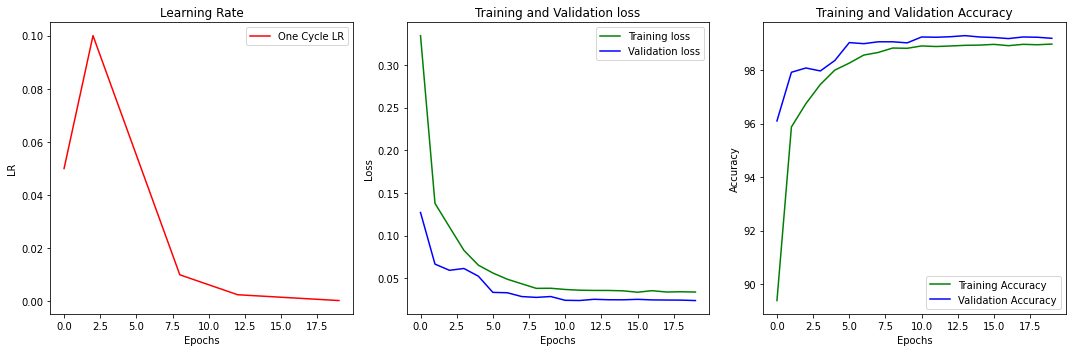

Total Incorrect Predictions 81


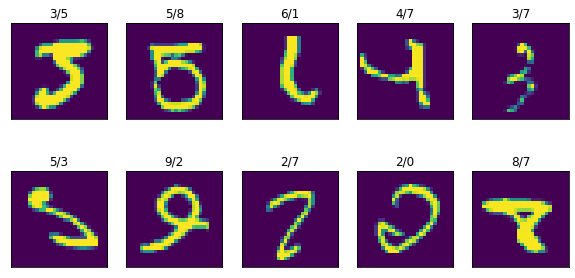

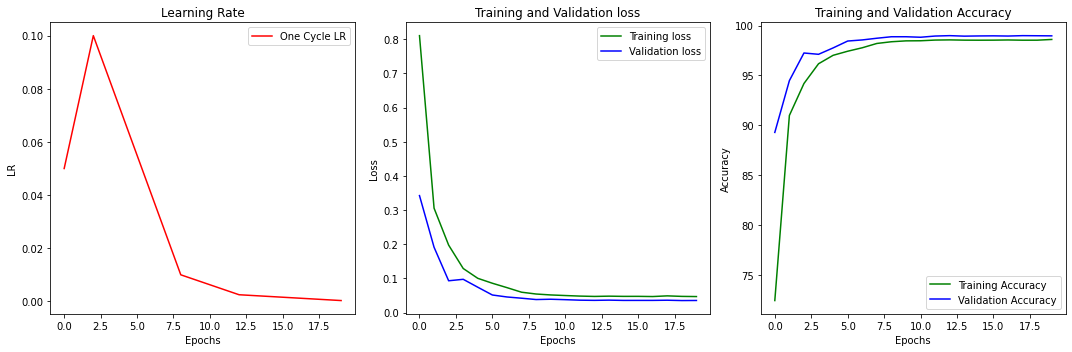

Total Incorrect Predictions 103


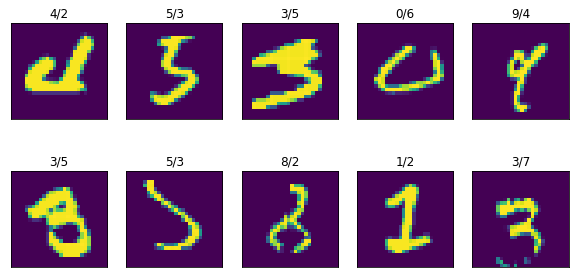

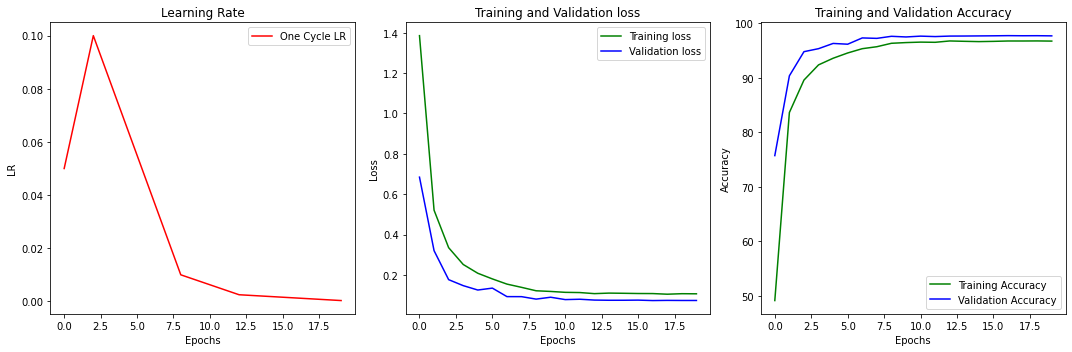

Total Incorrect Predictions 230


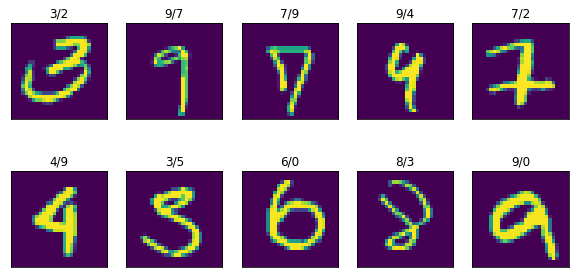

In [7]:
# Visualize network performance

from mnist.visualize import plot_network_performance
from mnist.utils import get_incorrrect_predictions
from mnist.visualize import plot_incorrect_predictions

from mnist.utils import get_all_predictions, get_incorrrect_predictions, prepare_confusion_matrix
from mnist.visualize import plot_confusion_matrix

for trainer in trainers:
#     trainer.print_best_model()
    plot_network_performance(epochs, trainer.schedule, trainer.list_train_loss, trainer.list_valid_loss, trainer.list_train_correct, trainer.list_valid_correct)

#     all_preds, all_targets = get_all_predictions(trainer.model, test_loader, device)
#     confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
#     plot_confusion_matrix(confusion_matrix, class_map, False)

    incorrect = get_incorrrect_predictions(trainer.model, test_loader, device)
    plot_incorrect_predictions(incorrect, class_map)

## Generate Consolidated Report

This report contains comparison between different model architectures.

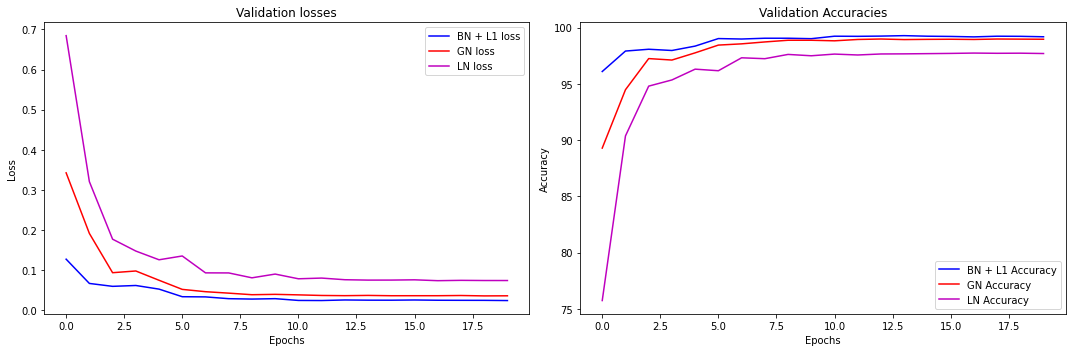

In [8]:
from mnist.visualize import plot_model_comparison

plot_model_comparison(trainers, epochs)